# Delhi Climate

This notebook is the first notebook of a time series training.

The data comes to Kaggle "Daily Climate time series data"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import autocorrelation_plot

In [2]:
#Importation of the train set and define date as index
df_train = pd.read_csv('DailyDelhiClimateTrain.csv', index_col =0, parse_dates=[0]).squeeze("columns")
df_train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
df_train.info()
# There are not null values and all the data are float

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [4]:
df_train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


To simplify the prediction, we will work only with the mean temperature ('meantemp')

In [5]:
data = df_train.meantemp

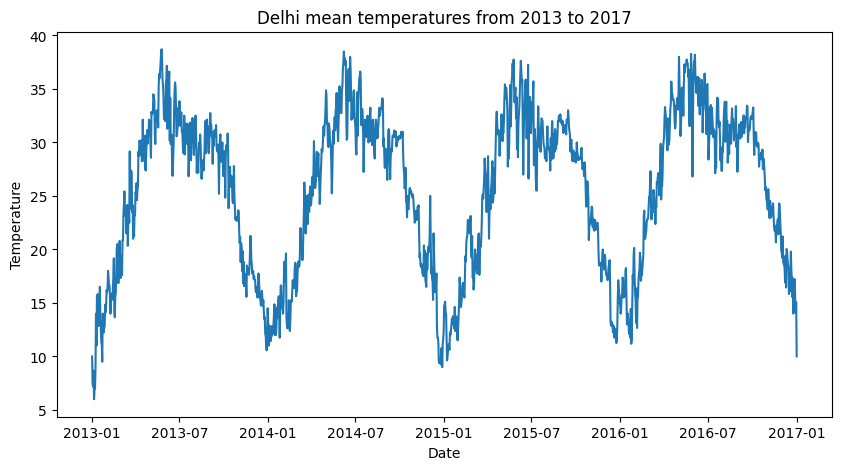

In [6]:
plt.figure(figsize=(10,5))
plt.plot(data)
plt.xlabel ('Date')
plt.ylabel('Temperature')
plt.title('Delhi mean temperatures from 2013 to 2017');

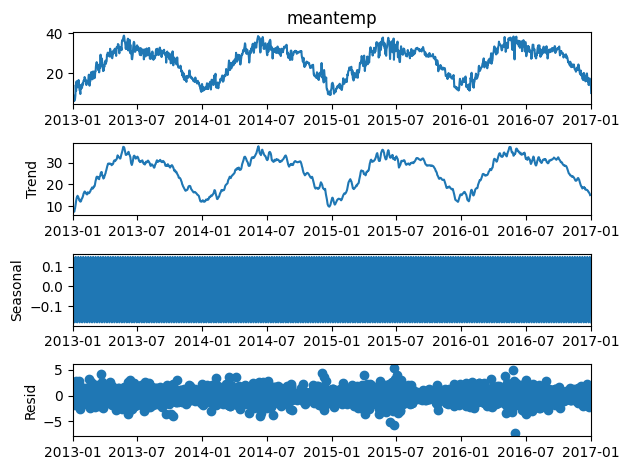

In [7]:
data_sd= seasonal_decompose(data)
data_sd.plot()
plt.show()

There is a monthly seasonality that is currently masked by considering the days. We need to sample the data by month.

In [8]:
dataM=data.resample('M')
dataM=dataM.mean()

In [9]:
dataM.tail()

date
2016-09-30    31.479768
2016-10-31    28.961680
2016-11-30    22.957378
2016-12-31    17.672565
2017-01-31    10.000000
Freq: M, Name: meantemp, dtype: float64

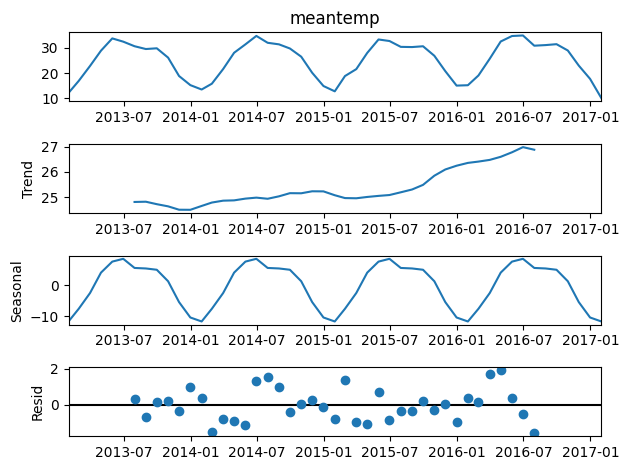

In [10]:
dataM_sd= seasonal_decompose(dataM)
dataM_sd.plot()
plt.show()

Now there is a readable seasonality. We can also see that trend increase from mid-2015

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

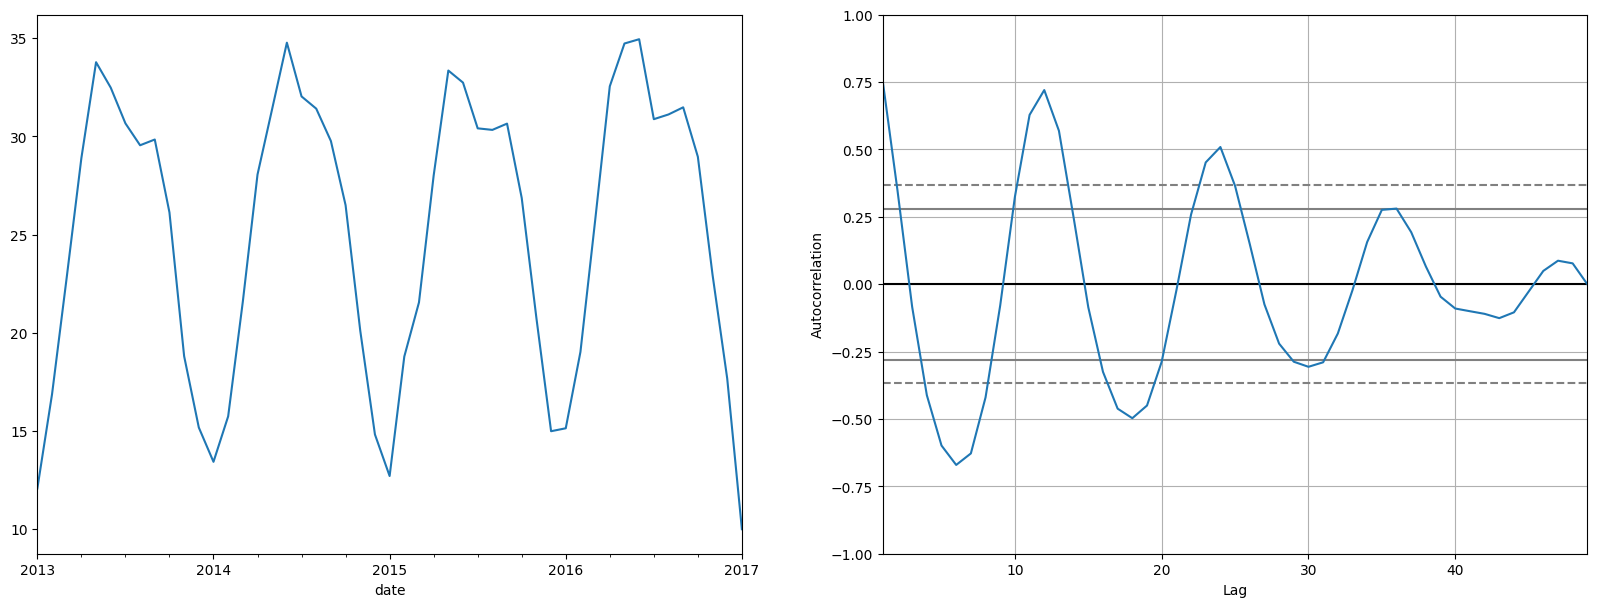

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

dataM.plot(ax=ax1)
autocorrelation_plot(dataM)

The autocorrelation plot seems to tends towards 0, so for a SARIMA model, d = 0. However, autocorrelation plot present seasonal peaks. We need to differentiate the data to delete the seasonality. That can be confirmed by the ADF test :

In [12]:
print('p-value du test ADF :',sm.tsa.stattools.adfuller(dataM)[1])

print('\nThe AFD test is higher than 0.05 so we need to differentiate the data.\nBecause of the seasonality, \
we need to differentiate with period=12 (12 month)')

p-value du test ADF : 0.7360356050589151

The AFD test is higher than 0.05 so we need to differentiate the data.
Because of the seasonality, we need to differentiate with period=12 (12 month)


In [13]:
dataM1=dataM.diff(periods =12).dropna()

print('p-value differentiate data :',sm.tsa.stattools.adfuller(dataM1)[1])
print('\nThe ADF test is lower than 0.05 so the data is stationnary.\nIn SARIMA model, d=0 and D=1')

p-value differentiate data : 0.0006228172601324139

The ADF test is lower than 0.05 so the data is stationnary.
In SARIMA model, d=0 and D=1


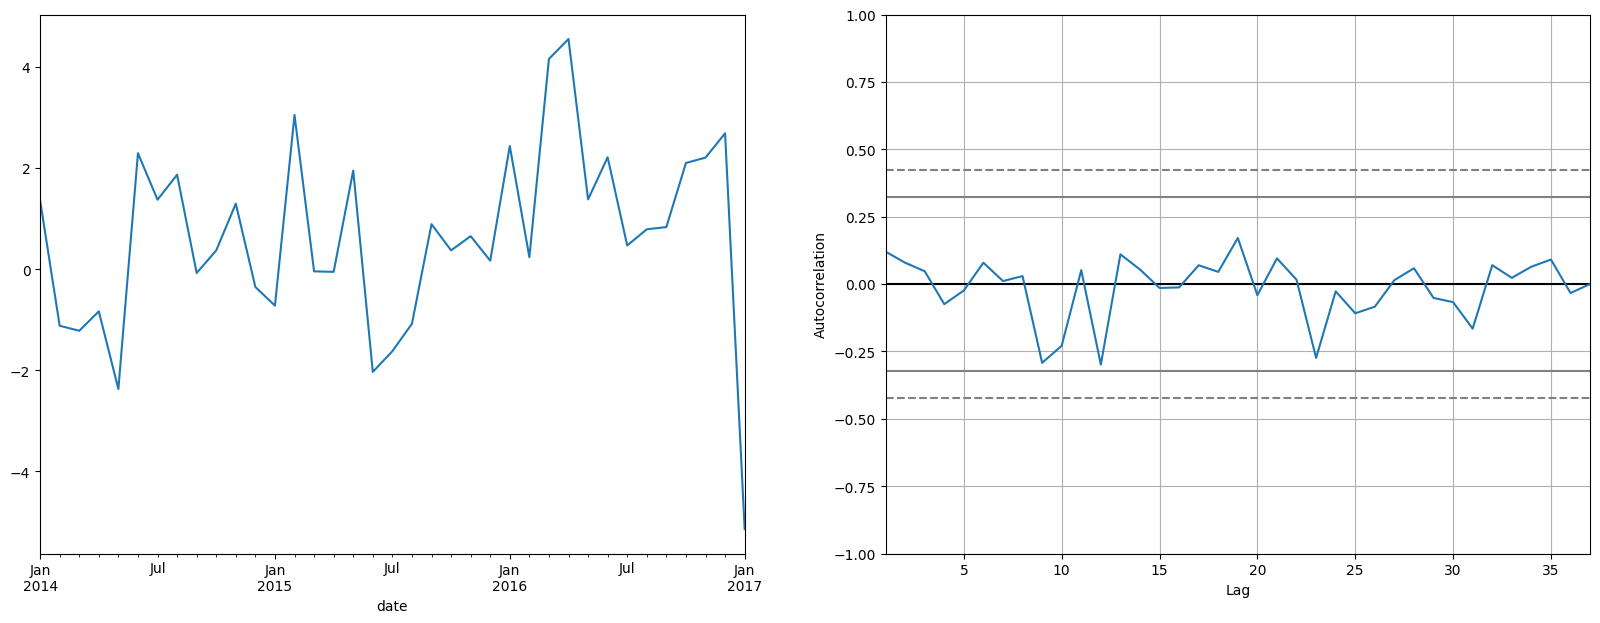

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7)) # Création de la figure et des axes

dataM1.plot(ax=ax1)
autocorrelation_plot(dataM1);

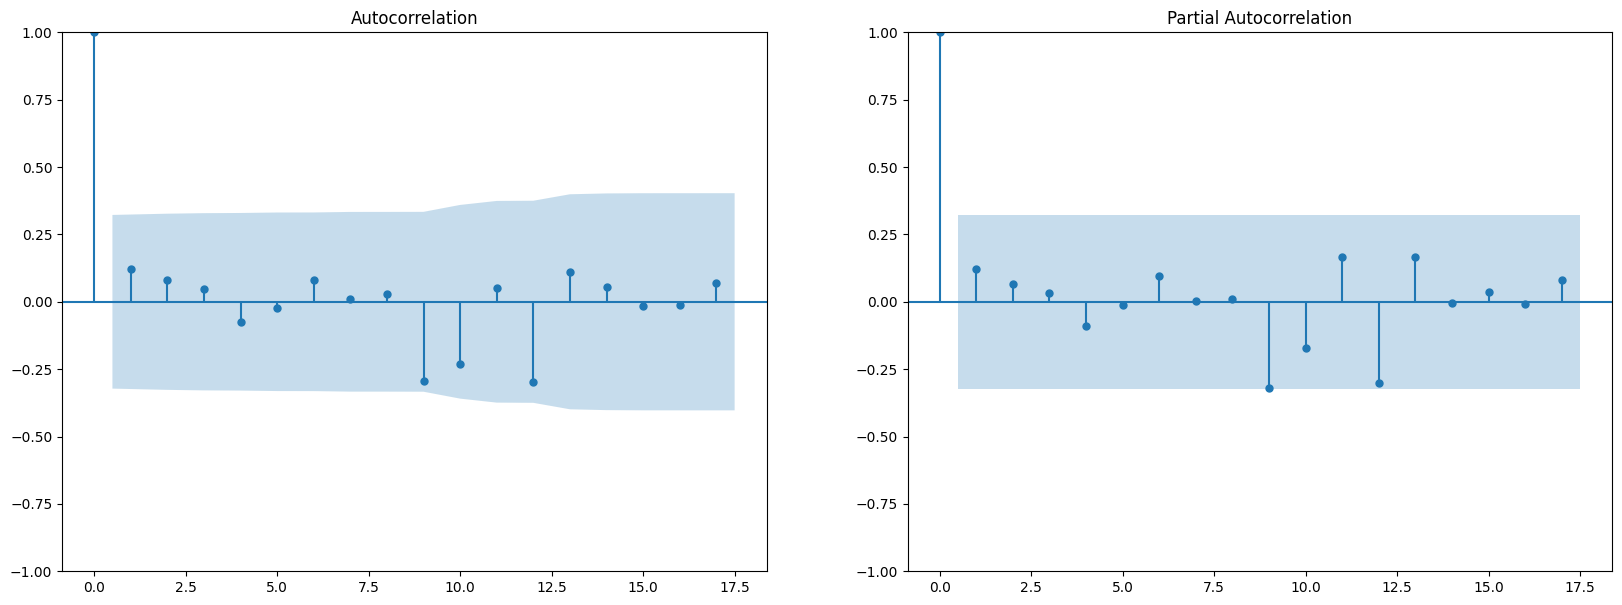

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,7))
plot_acf(dataM1, lags=17, ax=ax1)
plot_pacf(dataM1, lags=17, ax=ax2, method='ywm')

plt.show()

Now, it's time to determine p, q, P and Q parameters.

- (p,q) : 
In the both autocorrelation plot, the autoccorelations tend significatively to 0. So, we can, say p = 0 and q = 0.

- (P,Q) :
There are not seasonal peaks, so both equal 0.

In view of the elements, we can, for now, do SARIMA(0,0,0)(0,1,0)12

In [16]:
model=sm.tsa.SARIMAX(dataM,order=(0,0,0),seasonal_order=(0,1,0,12))
sarima=model.fit()
print(sarima.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59401D+00    |proj g|=  1.44160D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4      6      1     0     0   1.453D-06   1.578D+00
  F =   1.5776170371201517     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                SARIMAX Results                                 
Dep. Variable:                 meantemp   No. Observations:                   49
Model:             SARIMAX(0, 1,

 This problem is unconstrained.


Mean 6.53094117995003


''

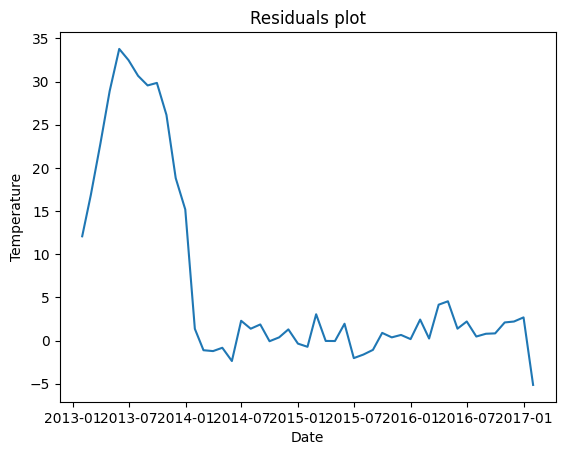

In [17]:
residuals = sarima.resid
print('Mean',residuals.mean())
plt.plot(residuals)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Residuals plot')
;

The Prob(Q) and Prob(JB) are higher than 0.05. It seems that the residuals are white noise and follow a normal distribution.

The residual mean is 6, it's low.

For AIC et BIC, the results are relatively high (156 and 158). Lower results are considered better. But overall, the SARIMA model provides a good fit to the data and performs well in terms of prediction.

Let's go to predict and evaluate the model

In [18]:
#True values
true_data = pd.read_csv('DailyDelhiClimateTest.csv', index_col =0, parse_dates=[0]).squeeze("columns")
true_data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [19]:
data_true=true_data['meantemp'].resample('M')
data_true=data_true.mean()

''

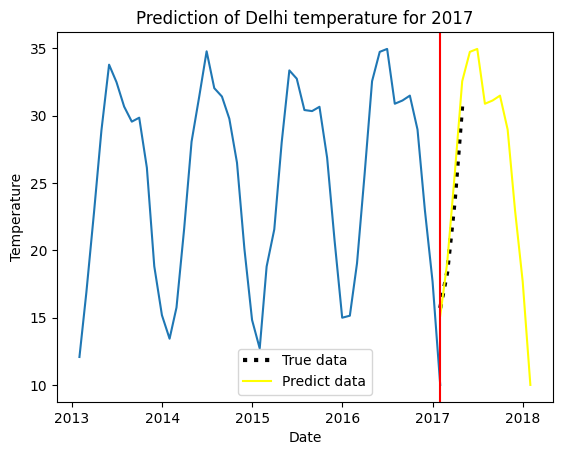

In [20]:
y_pred = sarima.predict(48,60)

import datetime

plt.plot(dataM)
plt.plot(data_true, color='black', label ='True data', linestyle=':', lw=3)
plt.plot(y_pred, color='yellow', label='Predict data')
plt.axvline(x=datetime.date(2017,1,31), c='red')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Prediction of Delhi temperature for 2017')
plt.legend()
;

In [21]:
rmse = np.sqrt(mean_squared_error(data_true, y_pred[:4]))
print('RMSE', rmse.round(2))

correlation, p_value = pearsonr(data_true, y_pred[:4])

print("Coefficient de corrélation de Pearson:", correlation)
print("P-valeur:", p_value)

RMSE 1.4
Coefficient de corrélation de Pearson: 0.9966848233796242
P-valeur: 0.003315176620375837


The temperature unit in data is °C. Therefore, a RMSE equal at 1.4 is pretty low. furthermore, the pearson coefficient is nearly equal to 1. That means the predict and true temperature are positively correlated and by extension, there are relatively equal.

The SARIMA model appears to be a suitable model for temperature prediction based on the available data. However, it is important to exercise caution. The actual values for prediction are only available until the month of May (inclusive). It is necessary to have the subsequent temperature observations to ensure that the remaining predictions align well with the real data.

That will be interesting to investigate the daily data or/and to consider the 3 other features.